# Olympics athletes and medals
128 years of Olympic history: athletes and results, basic bio data on athletes and medal results from Athens 1896 to Rio 2016.

Things to exaplore:
* What sports have been added on and removed over the past 100 years?
* Age distribution of medalists versus other competitors (there was a larger age variance in the earlier games)
* Participation of women in sport
* The home effect
* GDP and medals ratio
* Athletes to medals ratio
* Population to medals ratio

## I. Import and clean data

#### Import data

In [10]:
# Library import
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_rows', None)

In [12]:
# Data import (1986 – 2016)
data_all = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-08-06/olympics.csv")

# Data import (2020)
data_tokyo = pd.read_csv("/Users/nataschajademinnitt/Documents/5. Learning/Python/202408 Olympic Participation/Datasets/Tokyo 2020/2020_Olympics_Dataset.csv", encoding='latin1')

# Data import (2024)
data_paris = pd.read_csv("/Users/nataschajademinnitt/Documents/5. Learning/Python/202408 Olympic Participation/Datasets/Paris 2024/athletes.csv")

# Data import (nocs)
nocs = pd.read_csv('/Users/nataschajademinnitt/Documents/5. Learning/Python/202408 Olympic Participation/Datasets/NOCs/noc_regions.csv')

#### Cleaning the main dataset

In [14]:
# Remove winter games from main dataset
data_all = data_all[data_all['season'] == 'Summer']

# Remove figure skating and ice hockey games from main dataset (miscoded as summer games)
data_all = data_all.loc[(data_all['sport'] != 'Ice Hockey') & (data_all['sport'] != 'Figure Skating')]

# Recode Equestrianism as Equestrian
data_all.loc[data_all['sport'] == 'Equestrianism', 'sport'] = 'Equestrian'

# remove columns from main dataset
data_all = data_all.drop(columns=['games', 'season', 'team', 'id'])

# Removing duplicates
count_duplicates = data_all.loc[data_all.duplicated(keep=False), :].shape[0]
data_all.drop_duplicates(keep='first')
print(count_duplicates, 'duplicate rows have been removed')

2019 duplicate rows have been removed


#### Cleaning the Tokyo dataset

In [16]:
# drop columns from Tokyo dataset
data_tokyo = data_tokyo.drop(columns=['Unnamed: 0', 'Code', 'Country', 'Discipline', 'Rank'])

# Rename columns in Tokyo dataset
data_tokyo.rename(columns={'Name' : 'name', 'Gender' : 'sex', 'Age' : 'age', 
                     'NOC' : 'noc', 'Sport' : 'sport', 'Event' : 'event', 'Medal' : 'medal'}, inplace=True)

# Adding columns to Tokyo dataset
data_tokyo['year'] = 2020
data_tokyo['city'] = 'Tokyo'

# Reformat sex categories
data_tokyo['sex'] = data_tokyo['sex'].replace({'Male': 'M', 'Female': 'F'})

#### Cleaning the Paris dataset

In [18]:
# convert date of birth to age at the Paris games
data_paris['birth_date'] = pd.to_datetime(data_paris['birth_date']) # convert to date and time

date = datetime(2024, 7, 26)
data_paris['age'] = data_paris['birth_date'].apply(lambda dob: date.year - dob.year - ((date.month, date.day) < (dob.month, dob.day)))

# Remove the characters [' and '] from the 'sport' column
data_paris['sport'] = data_paris['disciplines'].str.replace(r'\[|\]|"|\'', '', regex=True).str.strip().str.replace(r',\s+', ', ', regex=True)
data_paris['event'] = data_paris['events'].str.replace(r'\[|\]|"|\'', '', regex=True).str.strip().str.replace(r',\s+', ', ', regex=True)

# Split the 'sport' and 'event' column by ', ' to create a list of events
data_paris['sport'] = data_paris['sport'].str.split(', ')
data_paris['event'] = data_paris['event'].str.split(', ')

# Use explode() to create new rows for each sport and event
data_paris = data_paris.explode('sport').reset_index(drop=True)
data_paris = data_paris.explode('event').reset_index(drop=True)

# drop columns from Paris dataset
keep = [1, 4, 6, 12, 13, 35, 36, 37]
data_paris = data_paris.iloc[:, keep]

# Rename columns in Paris dataset
data_paris.rename(columns={'code' : 'id', 'country_code' : 'noc', 'gender' : 'sex'}, inplace=True)

# Adding columns to Paris dataset
data_paris['year'] = 2024
data_paris['city'] = 'Paris'

# Reformat sex categories
data_paris['sex'] = data_paris['sex'].replace({'Male': 'M', 'Female': 'F'})

#### Cleaning the NOC dataset

In [20]:
# Drop notes column
nocs = nocs.drop(columns=['notes'])

# Rename NOC column
nocs.rename(columns={'NOC' : 'noc', 'region' : 'country'}, inplace=True)

#### Merging datasets

In [22]:
# Merging datasets
data = pd.concat([data_all, data_tokyo, data_paris], axis=0, ignore_index=True)

# Adding country column using NOC dataset
data = pd.merge(data, nocs, on='noc', how='left')

In [24]:
# Checking for null values
print('The dataset contains null values in the following columns:')
print(data.isnull().sum())

The dataset contains null values in the following columns:
name            0
sex             0
age          9175
height      66886
weight      68902
noc             0
year            0
city            0
sport           0
event           0
medal      216044
country      1139
dtype: int64


In [26]:
# Checking for outliers
data.describe().round(2)

,age,height,weight,year
count,243352.00,185641.00,183625.00,252527.00
mean,25.78,166.68,65.07,1981.79
std,6.58,40.05,23.84,32.58
min,10.00,0.00,0.00,1896.00
25%,22.00,167.00,58.00,1960.00
50%,25.00,175.00,68.00,1988.00
75%,29.00,183.00,78.00,2008.00
max,97.00,226.00,214.00,2024.00


In [28]:
# Filtered dataset to exclude discontinued sports
modern_sports = data.loc[(data['sport'] != 'Art Competitions')
& (data['sport'] != 'Croquet')
& (data['sport'] != 'Polo')
& (data['sport'] != 'Tug-Of-War')
& (data['sport'] != 'Motorboating')
& (data['sport'] != 'Roque')
& (data['sport'] != 'Racquets')
& (data['sport'] != 'Baseball/Softball')
& (data['sport'] != 'Softball')
& (data['sport'] != 'Karate')
& (data['sport'] != 'Jeu De Paume')
& (data['sport'] != 'Lacrosse')
& (data['sport'] != 'Cricket')
& (data['sport'] != 'Trampolining')
& (data['sport'] != 'Basque Pelota')
& (data['sport'] != 'Aeronautics')
& (data['sport'] != 'Aeronautics')
& (data['sport'] != 'Rugby')
& (data['sport'] != 'Alpinism')]

#### Overview of the data

In [31]:
check = data.groupby(['year', 'city']).nunique()
check

,,name,sex,age,height,weight,noc,sport,event,medal,country
year,city,,,,,,,,,,
1896,Athina,176,1,20,13,12,12,9,43,3,12
1900,Paris,1220,2,48,24,27,31,20,90,3,31
1904,St. Louis,650,2,49,27,41,15,18,95,3,14
1906,Athina,841,2,39,26,39,21,13,74,3,20
1908,London,2003,2,46,37,57,21,23,105,3,21
1912,Stockholm,2409,2,51,39,62,29,17,107,3,28
1920,Antwerpen,2590,2,49,44,68,29,23,154,3,29
1924,Paris,3256,2,59,44,71,45,20,131,3,45
1928,Amsterdam,3246,2,62,48,69,46,17,122,3,46


## II. How have the Games changed over the past 128 years?

### Country Participation

In [1020]:
# Group by year and count unique countries
unique_countries = data.groupby('year')['noc'].nunique()

# Convert the Series to a DataFrame
unique_countries = unique_countries.reset_index()

# Rename the columns
unique_countries.columns = ['year', 'all countries']

In [1021]:
# Creating a df of countries and whether they competed in a game

# Create a pivot table with 'country' as index and 'year' as columns
participation_pivot = data.pivot_table(index='country', columns='year', aggfunc='size', fill_value=0)

# Replace the counts with 1 (participation) and 0 (non-participation)
participation_pivot[participation_pivot > 0] = 1

# Reset index to have 'country' as a column
participation_pivot = participation_pivot.reset_index()

# export to excel
participation_pivot.to_excel('olympic_participation.xlsx', index=False)

In [1022]:
# Which contries have completed in the most games since 1896
competing_countires = data.groupby('country')['year'].nunique()

# Convert the Series to a DataFrame
competing_countires = competing_countires.reset_index()

# Rename the columns
competing_countires.columns = ['Countries', 'Games']

competing_countires.sort_values(by='Games', ascending=False).head(10)

,Countries,Games
87,Italy,31
177,Switzerland,31
63,France,31
190,UK,31
10,Australia,31
69,Greece,31
50,Denmark,30
176,Sweden,30
191,USA,30
11,Austria,30


In [1023]:
# Which years did Austria, Denmark, USA and Sweden not compete?
years_30 = participation_pivot.loc[participation_pivot['country'].isin(['Austria', 'USA', 'Sweden', 'Denmark'])]

pd.set_option('display.max_columns', None)

years_30

year,country,1896,1900,1904,1906,1908,1912,1920,1924,1928,1932,1936,1948,1952,1956,1960,1964,1968,1972,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016,2020,2024
11,Austria,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
50,Denmark,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
176,Sweden,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
191,USA,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1


### Sports Included Over Time

In [991]:
# Pivot table with sport and year
df = data.pivot_table(index='sport', columns='year', aggfunc='size', fill_value=0)

# Replace the counts with 1 (participation) and 0 (non-participation)
df[df > 0] = 1

# Adding a total column
df['Total'] = df.iloc[:, 1:].sum(axis=1)

# Sorting by the sports that appeared the most using Total
df = df.sort_values(by='Total', ascending=False)

# dropping the total column for the figure
df = df.drop(columns='Total')

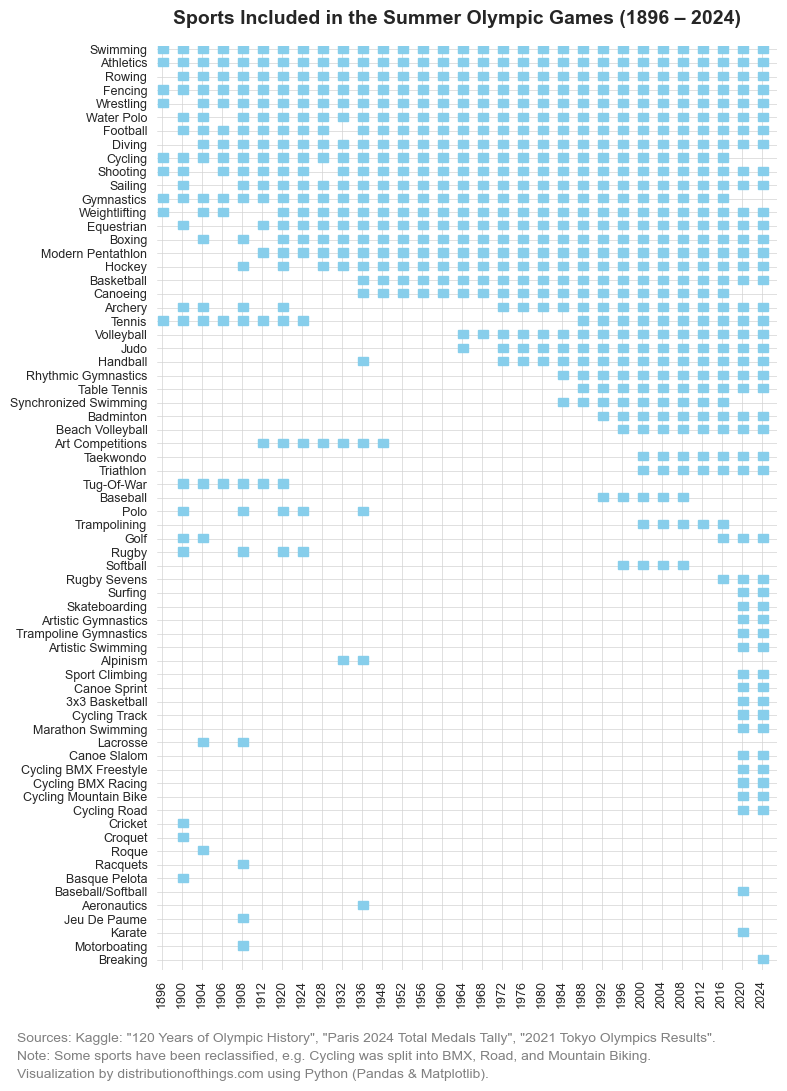

In [1606]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 12))

# Plot each square for participation (where there's a 1)
for y, sport in enumerate(df.index):
    for x, year in enumerate(df.columns):
        if df.loc[sport, year] == 1:
             ax.add_patch(plt.Rectangle((x +0.025, y -0.1), 0.5, 0.6, fill=True, color="skyblue"))

# Formatting the plot
ax.set_xticks(np.arange(len(df.columns)) + 0.25)
ax.set_yticks(np.arange(len(df.index)) + 0.25)
ax.set_xticklabels(df.columns, rotation=90, fontsize=9)
ax.set_yticklabels(df.index, fontsize=9)

# Adding gridlines
ax.set_xlim(0, len(df.columns))
ax.set_ylim(0, len(df.index))
ax.invert_yaxis()
plt.grid(True, which='both', axis='both', linewidth=0.5, color='lightgray')

# Annotate
plt.suptitle('Sports Included in the Summer Olympic Games (1896 – 2024)', 
             fontsize=14, fontweight='bold', ha='center', y=0.91)
plt.figtext(-0.05, +0.05, 'Sources: Kaggle: "120 Years of Olympic History", "Paris 2024 Total Medals Tally", "2021 Tokyo Olympics Results".', 
            wrap=True, horizontalalignment='left', fontsize=10, color='gray')
plt.figtext(-0.05, +0.035, 'Note: Some sports have been reclassified, e.g. Cycling was split into BMX, Road, and Mountain Biking.', 
            wrap=True, horizontalalignment='left', fontsize=10, color='gray')
plt.figtext(-0.05, +0.02, 'Visualization by distributionofthings.com using Python (Pandas & Matplotlib).', 
            wrap=True, horizontalalignment='left', fontsize=10, color='gray')

# Remove the axis spines for a cleaner look
ax.spines[:].set_visible(False)

plt.savefig('Sports Included in the Summer Olympic Games (1896 – 2024).png', dpi=300, bbox_inches='tight')

### Gender Participation Across Sports in the Summer Olympic Games (1896 – 2024)

In [1089]:
# Filtering the dataset to only include women
df_w = data[data['sex'] == 'F']

# Pivot table with sport and year
df_w = df_w.pivot_table(index='sport', columns='year', aggfunc='size', fill_value=0)

# Replace the counts with 1 (participation) and 0 (non-participation)
df_w[df_w > 0] = 1

df_w = df_w.reindex(df.index, fill_value=0)

# Convert all columns to integers (assuming year columns are integers)
df_w.columns = df_w.columns.astype(int)

# Add the missing '1896' column with values set to 0
df_w[1896] = 0

# Sort the columns after adding 1986
df_w = df_w.reindex(sorted(df.columns), axis=1)

## Same for men
# Filtering the dataset to only include men
df_m = data[data['sex'] == 'M']

# Pivot table with sport and year
df_m = df_m.pivot_table(index='sport', columns='year', aggfunc='size', fill_value=0)

# Replace the counts with 1 (participation) and 0 (non-participation)
df_m[df_m > 0] = 1

df_m = df_m.reindex(df.index, fill_value=0)

# Pivot table where only women participated
df_female_only = (df_w == 1) & (df_m == 0)

# Convert to integers
df_female_only = df_female_only.astype(int)

# Pivot table where only men participated
df_male_only = (df_w == 0) & (df_m == 1)

# Convert to integers
df_male_only = df_male_only.astype(int)

# Pivot table where men and women participated
df_both = (df_w == 1) & (df_m == 1)

# Convert to integers
df_both = df_both.astype(int)

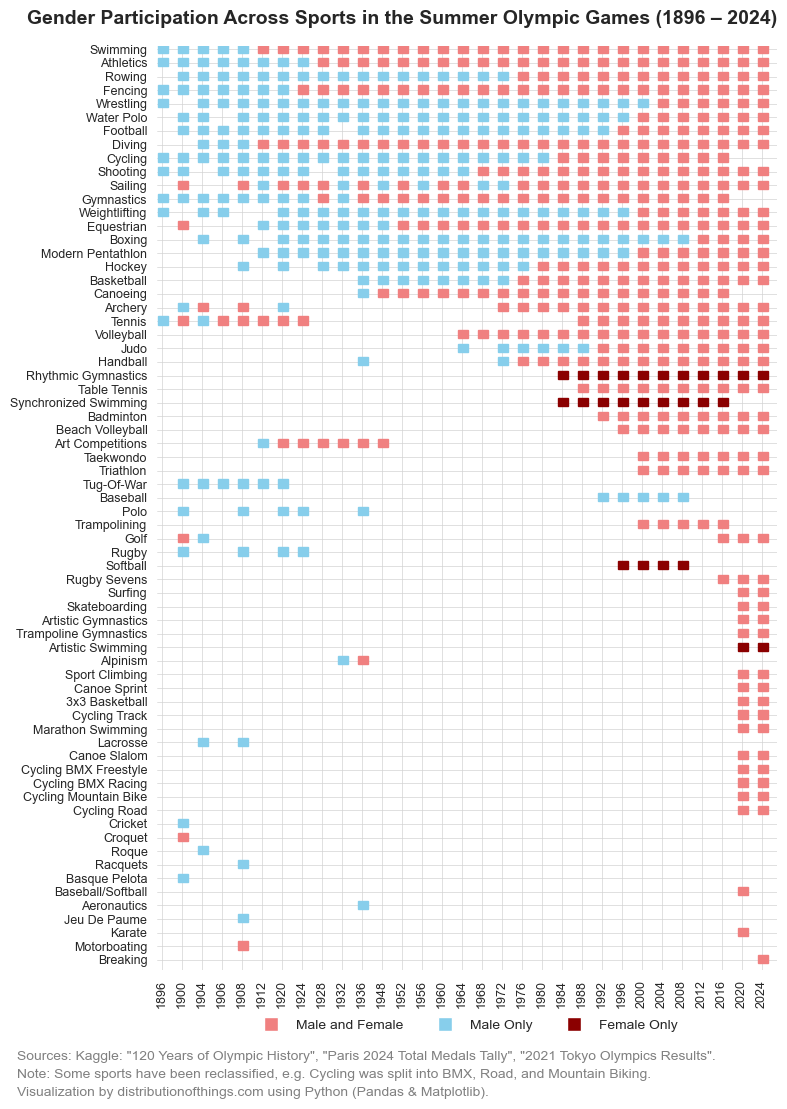

In [1598]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 12))

# Plot each square for participation (where there's a 1)
for y, sport in enumerate(df_both.index):
    for x, year in enumerate(df_both.columns):
        if df_both.loc[sport, year] == 1:
            ax.add_patch(plt.Rectangle((x +0.025, y -0.1), 0.5, 0.6, fill=True, color="lightcoral"))

# Plot each square for participation (where there's a 1)
for y, sport in enumerate(df_male_only.index):
    for x, year in enumerate(df_male_only.columns):
        if df_male_only.loc[sport, year] == 1:
            ax.add_patch(plt.Rectangle((x +0.025, y -0.1), 0.5, 0.6, fill=True, color="skyblue"))

# Plot each square for participation (where there's a 1)
for y, sport in enumerate(df_female_only.index):
    for x, year in enumerate(df_female_only.columns):
        if df_female_only.loc[sport, year] == 1:
            ax.add_patch(plt.Rectangle((x +0.025, y -0.1), 0.5, 0.6, fill=True, color="darkred"))

# Formatting the plot
ax.set_xticks(np.arange(len(df_w.columns)) + 0.25)
ax.set_yticks(np.arange(len(df_w.index)) + 0.25)
ax.set_xticklabels(df_w.columns, rotation=90, fontsize=9)
ax.set_yticklabels(df_w.index, fontsize=9)

# Legend
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='Male and Female'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='skyblue', markersize=10, label='Male Only'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='darkred', markersize=10, label='Female Only')
    ],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.04),
    ncol=3,
    frameon=False
)

# Adding gridlines
ax.set_xlim(0, len(df_w.columns))
ax.set_ylim(0, len(df_w.index))
ax.invert_yaxis()
plt.grid(True, which='both', axis='both', linewidth=0.5, color='lightgray')

# Annotate
plt.suptitle('Gender Participation Across Sports in the Summer Olympic Games (1896 – 2024)', 
             fontsize=14, fontweight='bold', ha='right', x=0.9, y=0.91)
plt.figtext(-0.05, +0.035, 'Sources: Kaggle: "120 Years of Olympic History", "Paris 2024 Total Medals Tally", "2021 Tokyo Olympics Results".', 
            wrap=True, horizontalalignment='left', fontsize=10, color='gray')
plt.figtext(-0.05, +0.02, 'Note: Some sports have been reclassified, e.g. Cycling was split into BMX, Road, and Mountain Biking.', 
            wrap=True, horizontalalignment='left', fontsize=10, color='gray')
plt.figtext(-0.05, +0.005, 'Visualization by distributionofthings.com using Python (Pandas & Matplotlib).', 
            wrap=True, horizontalalignment='left', fontsize=10, color='gray')

# Remove the axis spines for a cleaner look
ax.spines[:].set_visible(False)

plt.savefig('Gender Participation Across Sports in the Summer Olympic Games (1896 – 2024).png', dpi=300, bbox_inches='tight')

### Women in the Games

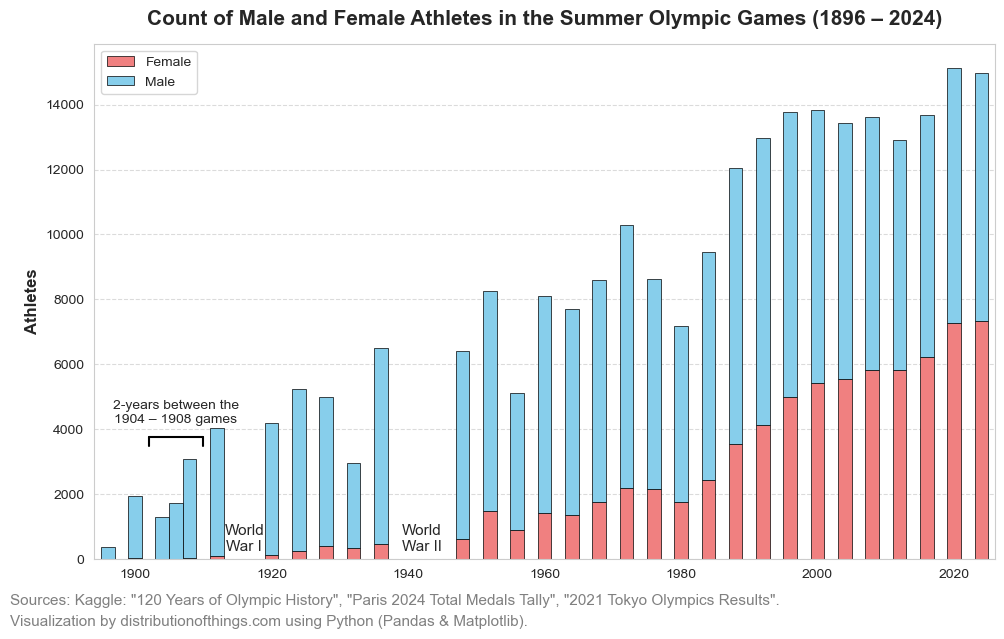

In [1626]:
# Count sex of participants for each game, unstack sex column
sex_year = data.groupby(['year', 'sex']).size().unstack(fill_value=0)
sex_year.columns = ['F', 'M']
sex_year.reset_index(inplace=True)

# Set the style for the plot
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
bar_width = 2

# Creating the bar plot
plt.bar(sex_year['year'], sex_year['F'], width=bar_width, label='Female', color='lightcoral',
       edgecolor='black', linewidth=0.5)
plt.bar(sex_year['year'], sex_year['M'], width=bar_width, bottom=sex_year['F'], label='Male', color='skyblue',
       edgecolor='black', linewidth=0.5)

# Customize the plot
plt.title('Count of Male and Female Athletes in the Summer Olympic Games (1896 – 2024)', fontsize= 15, fontweight='bold', ha='center', y=1.02)
plt.ylabel('Athletes', fontsize=12, fontweight='bold')
plt.legend()
plt.xlim(1894, 2026)
plt.grid(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate
plt.plot([1902, 1910], [3750, 3750], color='black')  # Horizontal line
plt.plot([1902, 1902], [3750, 3500], color='black')  # Vertical line for 1904
plt.plot([1910, 1910], [3750, 3500], color='black')  # Vertical line for 1908

plt.annotate('2-years between the\n1904 – 1908 games', xy=(1906, 4200), fontsize=10, ha='center')
plt.annotate('World\nWar I', xy=(1916, 250), fontsize=11, ha='center')
plt.annotate('World\nWar II', xy=(1942, 250), fontsize=11, ha='center')


plt.figtext(0, -0.015, 'Sources: Kaggle: "120 Years of Olympic History", "Paris 2024 Total Medals Tally", "2021 Tokyo Olympics Results".', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')
plt.figtext(0, -0.05, 'Visualization by distributionofthings.com using Python (Pandas & Matplotlib).', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')

# Show and save the plot
plt.tight_layout()
plt.savefig('Count of Male and Female Athletes in the Games.png', dpi=300, bbox_inches='tight')
plt.show()

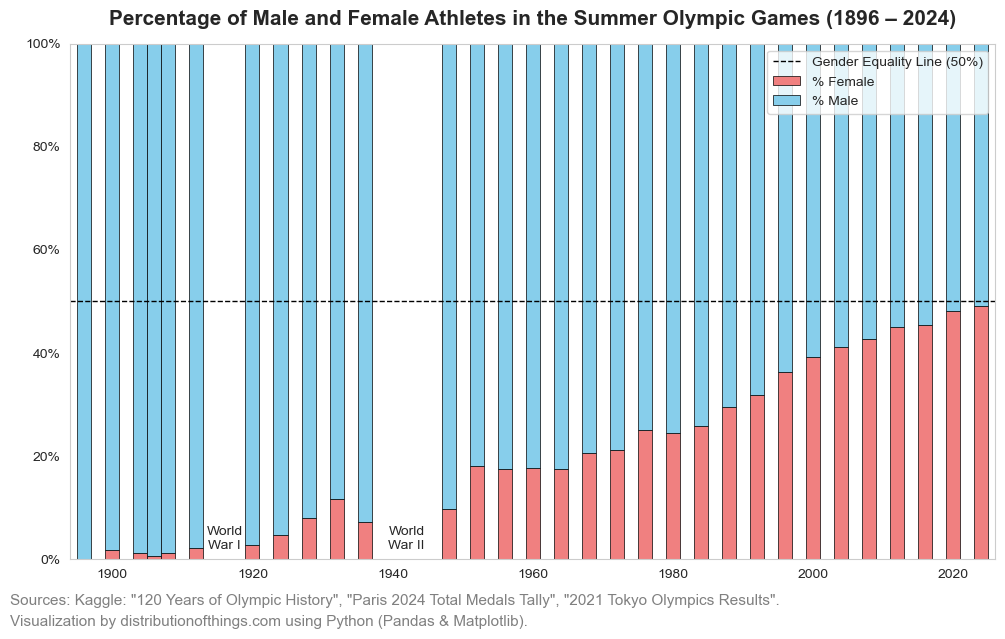

In [1628]:
# Count sex of participants for each game, unstack sex column
sex_year = data.groupby(['year', 'sex']).size().unstack(fill_value=0)
sex_year = (sex_year.div(sex_year.sum(axis=1), axis=0) * 100)
sex_year.columns = ['% F', '% M']
sex_year.reset_index(inplace=True)

# Set the style for the plot
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
bar_width = 2

# Creating the bar plot
plt.bar(sex_year['year'], sex_year['% F'], width=bar_width, label='% Female', color='lightcoral', 
        edgecolor='black', linewidth=0.5)
plt.bar(sex_year['year'], sex_year['% M'], width=bar_width, bottom=sex_year['% F'], label='% Male', color='skyblue',
       edgecolor='black', linewidth=0.5)
plt.axhline(y=50, color='black', linestyle='--', linewidth=1, label='Gender Equality Line (50%)')

# Customize the plot
plt.title('Percentage of Male and Female Athletes in the Summer Olympic Games (1896 – 2024)', fontsize=15, fontweight='bold', ha='center', y=1.02)
plt.legend(title='Sex')
plt.ylim(0, 100)
plt.xlim(1894, 2026)
plt.grid(False)
plt.legend()

import matplotlib.ticker as mticker
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x)}%'))

plt.figtext(0, -0.015, 'Sources: Kaggle: "120 Years of Olympic History", "Paris 2024 Total Medals Tally", "2021 Tokyo Olympics Results".', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')
plt.figtext(0, -0.05, 'Visualization by distributionofthings.com using Python (Pandas & Matplotlib).', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')

plt.annotate('World\nWar I', xy=(1916, 2), fontsize=10, ha='center')
plt.annotate('World\nWar II', xy=(1942, 2), fontsize=10, ha='center')

# Show and save the plot
plt.tight_layout()
plt.savefig('Percentage of Male and Female Athletes Over Time.png', dpi=300, bbox_inches='tight')
plt.show()

## III. How old are Olympic Athletes?

### Overall age distribution

In [300]:
import seaborn as sns
import matplotlib.pyplot as plt

# Grouping years into three categories
age_box = data.copy()

age_box['yearcat'] = np.where(age_box['year'] <= 1936, '1896 – 1936',
                               np.where((age_box['year'] > 1936) & (age_box['year'] <= 1984), '1948 – 1984',
                               '1988 – 2024'))

age_box = age_box[['yearcat', 'age', 'sex']]

In [ ]:
plt.figure(figsize=(8, 6))

# Use violinplot instead of swarmplot
sns.violinplot(data=age_box, x='yearcat', y='age', palette='rocket', order=['1896 – 1936', '1948 – 1984', '1988 – 2024'])

plt.title('Age Distribution of Olympians Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Olympic Year Categories', fontsize=12)
plt.ylabel('Age', fontsize=12)

plt.show()

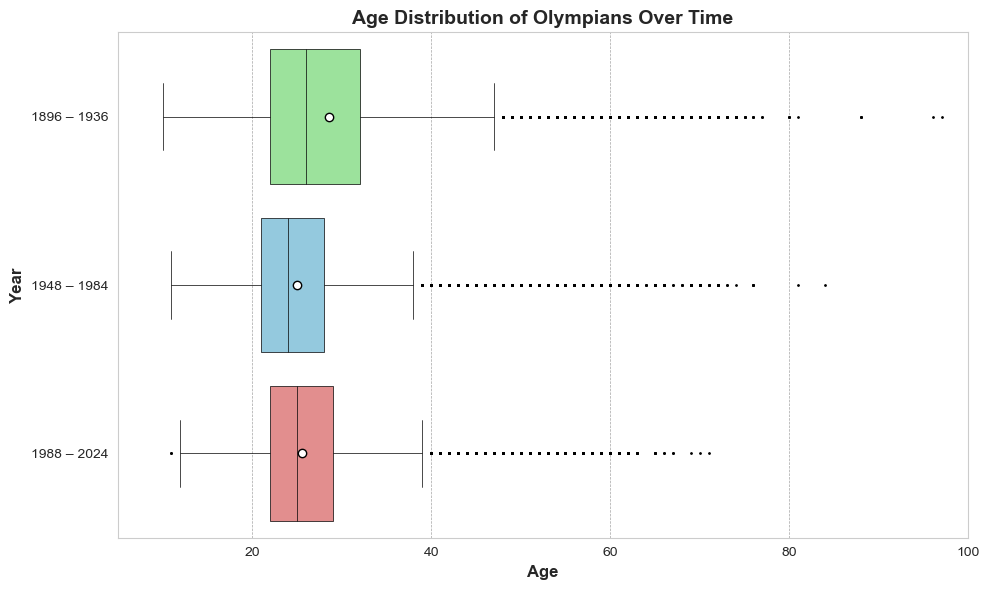

In [302]:
# Define the custom order
custom_order = ['1896 – 1936', '1948 – 1984', '1988 – 2024']
custom_palette = ['lightgreen', 'skyblue', 'lightcoral']

# Set the style for the plot
sns.set_style("whitegrid")

# Set the figure size
plt.figure(figsize=(10, 6))

# Customize outlier markers
flierprops = dict(marker='o', markerfacecolor='black', markersize=1, linestyle='none')

# Create the box plot with custom outlier markers
sns.boxplot(data=age_box, x='age', y='yearcat', palette=custom_palette, flierprops=flierprops, linewidth=0.5, linecolor='black', order=custom_order,
           showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})

plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Labelling
plt.title('Age Distribution of Olympians Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12, fontweight='bold')
plt.ylabel('Year', fontsize=12, fontweight='bold')
plt.xlim(5, 100)
plt.tight_layout()

# Save figure
plt.savefig('Age Distribution of Olympians Over Time.png', dpi=300)

<Figure size 800x600 with 0 Axes>

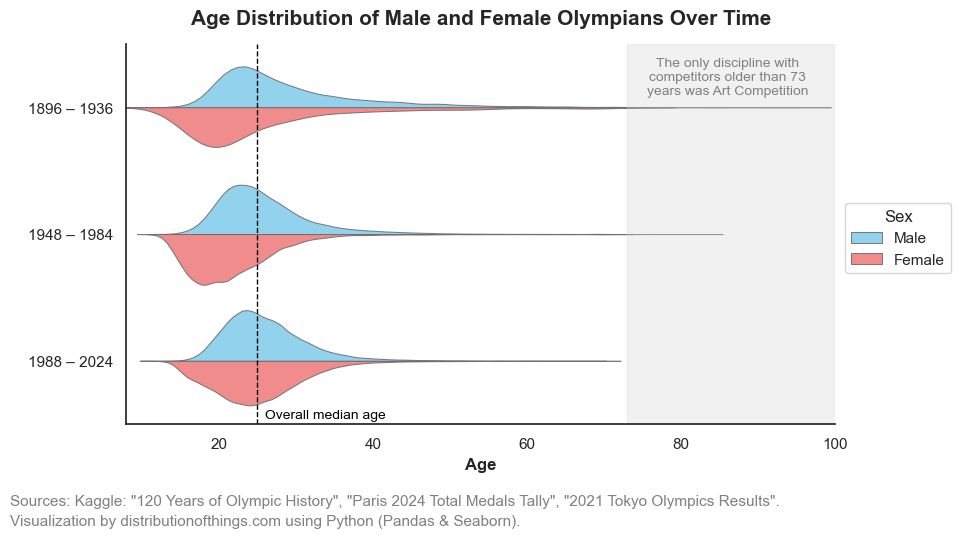

In [827]:
age_box['sex'] = age_box['sex'].replace({'M': 'Male', 'F': 'Female'})

# Set the style for the plot
sns.set_style("white")

custom_palette = ['skyblue', 'lightcoral']

# Set the overall figure size
plt.figure(figsize=(8, 6))

# Calculate the median age across all periods
overall_median_age = age_box['age'].median()

# Use catplot for violin with adjusted aspect ratio
g = sns.catplot(
    data=age_box, x="age", y="yearcat", hue="sex",
    kind="violin", split=True, inner=None,
    palette=custom_palette,
    order=['1896 – 1936', '1948 – 1984', '1988 – 2024'],
    saturation=1, linewidth=0.75, aspect=1.5,
    height=5, alpha=0.9,
    legend=True
)

# Add labels and title
plt.title('Age Distribution of Male and Female Olympians Over Time', fontsize=15, fontweight='bold', y=1.03)
plt.xlabel('Age', fontsize=12, fontweight='bold')
g.set(ylabel="")
plt.xlim(8, 100)
g._legend.set_bbox_to_anchor((1.12, 0.6))
g._legend.set_title("Sex")
g._legend.set_frame_on(True)


# Annotate
g.ax.axvspan(73, 100, color='lightgrey', alpha=0.3, label="Art Competitions")
g.ax.axvline(overall_median_age, color='black', linestyle='--', label=f'Overall Median Age: {overall_median_age:.1f}', lw=1)
plt.annotate('The only discipline with\ncompetitors older than 73\nyears was Art Competition', xy=(86, -0.1), fontsize=10, color='grey', ha='center')
plt.annotate('Overall median age', xy=(26, 2.45), fontsize=10, color='black', ha='left')

# Add sources
plt.figtext(0, -0.03, 'Sources: Kaggle: "120 Years of Olympic History", "Paris 2024 Total Medals Tally", "2021 Tokyo Olympics Results".', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')
plt.figtext(0, -0.07, 'Visualization by distributionofthings.com using Python (Pandas & Seaborn).', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')

# Save
plt.tight_layout()
plt.savefig('Age Distribution of Male and Female Athletes Over Time.png', dpi=300, bbox_inches='tight')
plt.show()

In [829]:
# Checking the spread for each year category
age_box.groupby('yearcat').describe()

age                                                   
                count       mean       std   min   25%   50%   75%   max
yearcat                                                                 
1896 – 1936   30296.0  28.645465  9.597689  10.0  22.0  26.0  32.0  97.0
1948 – 1984   76859.0  24.986937  6.416711  11.0  21.0  24.0  28.0  84.0
1988 – 2024  136197.0  25.588214  5.601287  11.0  22.0  25.0  29.0  71.0

In [843]:
# Checking the spread for the Paris 2024 games
paris = data.loc[(data['year'] == 2024)]
paris['age'].describe()

count    14968.000000
mean        26.294762
std          5.550484
min         11.000000
25%         23.000000
50%         26.000000
75%         29.000000
max         69.000000
Name: age, dtype: float64

### Age distribution by sport

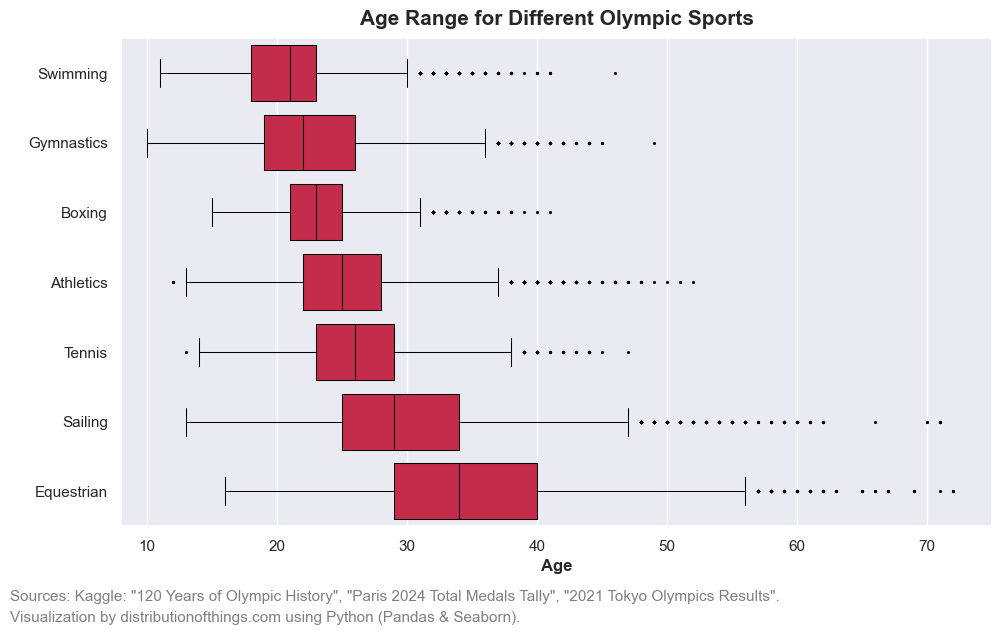

In [938]:
# Filter data set to only include selected sports
age_sports = data.loc[(data['sport'] == 'Swimming')
| (data['sport'] == 'Sailing')
| (data['sport'] == 'Equestrian')
| (data['sport'] == 'Gymnastics')
| (data['sport'] == 'Athletics')
| (data['sport'] == 'Boxing')
| (data['sport'] == 'Tennis')]

# Setting the order of the y-axis (Q1 for each sport)
q1_order = age_sports.groupby('sport')['age'].quantile(0.25).sort_values()
ordered_sports = q1_order.index

# Set the style for the plot
sns.set_style("darkgrid")

# Set the figure size
plt.figure(figsize=(10, 6))

# Customize outlier markers
flierprops = dict(marker='o', markerfacecolor='black', markersize=1.25, linestyle='none')

# Create the box plot with custom outlier markers
sns.boxplot(data=age_sports, x='age', y='sport', order=ordered_sports, color='crimson', flierprops=flierprops, linewidth=0.75, linecolor='black')

# Labelling
plt.title('Age Range for Different Olympic Sports', fontsize=15, fontweight='bold', y=1.01)
plt.xlabel('Age', fontsize=12, fontweight='bold')
plt.ylabel('')
plt.xlim(8, 75)

# Citations
plt.figtext(0, -0.015, 'Sources: Kaggle: "120 Years of Olympic History", "Paris 2024 Total Medals Tally", "2021 Tokyo Olympics Results".', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')
plt.figtext(0, -0.05, 'Visualization by distributionofthings.com using Python (Pandas & Seaborn).', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')

# Save figure
plt.tight_layout()
plt.savefig('Age Range for Different Olympic Sports.png', dpi=300, bbox_inches='tight')
plt.show()

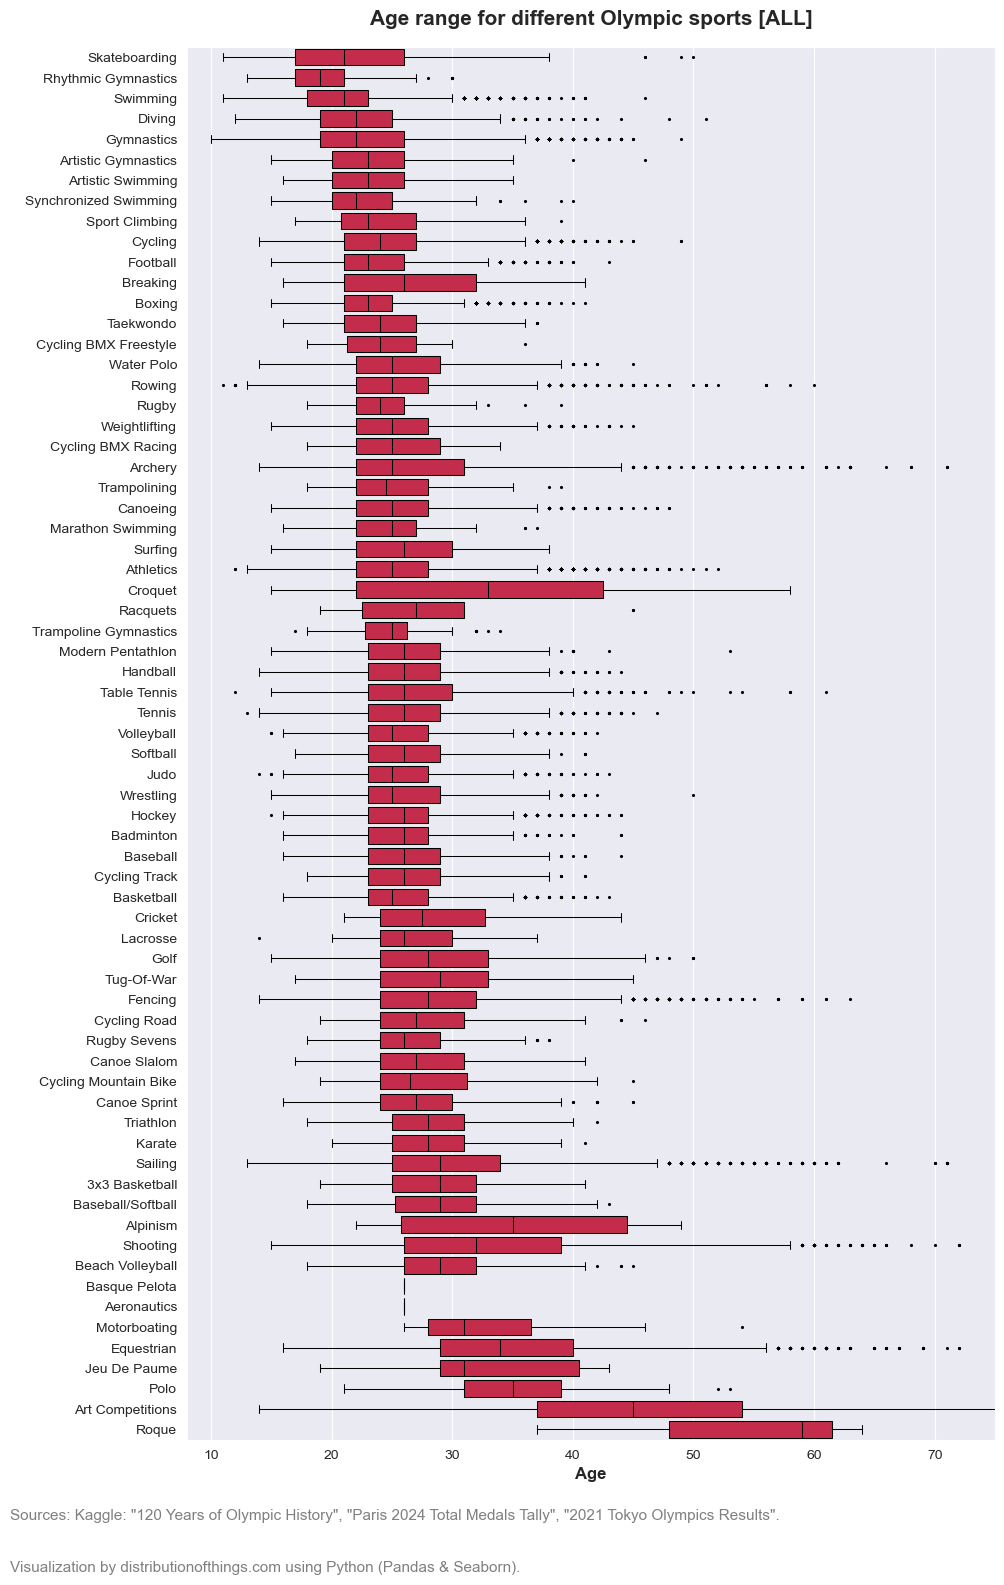

In [37]:

# Setting the order of the y-axis (Q1 for each sport)
q1_order = data.groupby('sport')['age'].quantile(0.25).sort_values()
ordered_sports = q1_order.index

# Set the style for the plot
sns.set_style("darkgrid")

# Set the figure size
plt.figure(figsize=(10, 15))

# Customize outlier markers
flierprops = dict(marker='o', markerfacecolor='black', markersize=1.25, linestyle='none')

# Create the box plot with custom outlier markers
sns.boxplot(data=data, x='age', y='sport', order=ordered_sports, color='crimson', flierprops=flierprops, linewidth=0.75, linecolor='black')

# Labelling
plt.title('Age range for different Olympic sports [ALL]', fontsize=15, fontweight='bold', y=1.01)
plt.xlabel('Age', fontsize=12, fontweight='bold')
plt.ylabel('')
plt.xlim(8, 75)

# Citations
plt.figtext(0, -0.015, 'Sources: Kaggle: "120 Years of Olympic History", "Paris 2024 Total Medals Tally", "2021 Tokyo Olympics Results".', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')
plt.figtext(0, -0.05, 'Visualization by distributionofthings.com using Python (Pandas & Seaborn).', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')

# Save figure
plt.tight_layout()
plt.savefig('Age Range for Different Olympic Sports.png', dpi=300, bbox_inches='tight')
plt.show()

In [942]:
# Checking the spread for the Paris 2024 games
check = data.loc[(data['sport'] == 'Equestrian')]
check['age'].describe()

count    6985.000000
mean       34.895634
std         8.646412
min        16.000000
25%        29.000000
50%        34.000000
75%        40.000000
max        72.000000
Name: age, dtype: float64

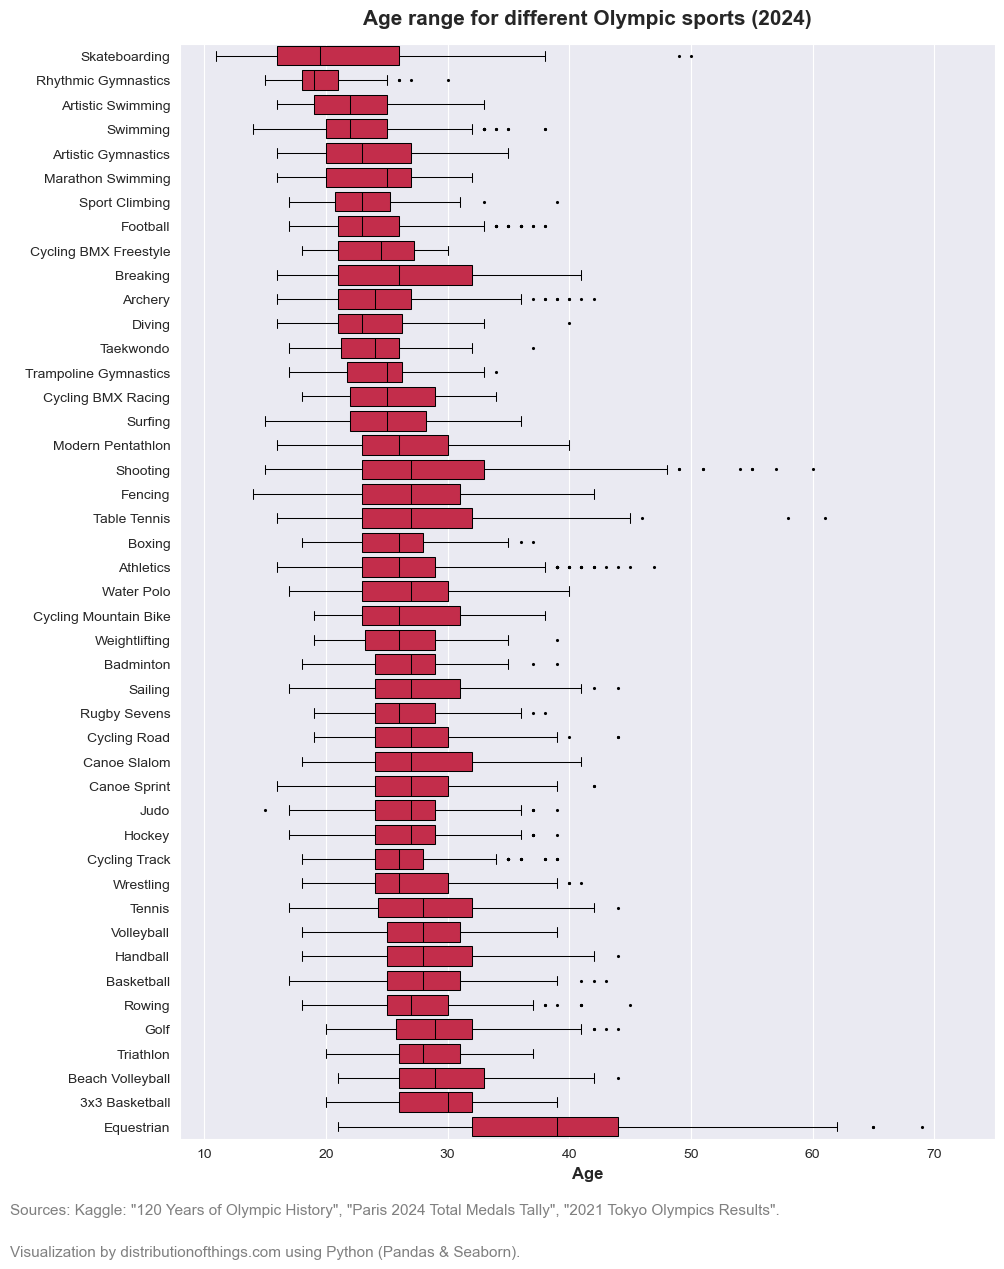

In [41]:
# Filter data set to only include selected sports
recent = data.loc[(data['year'] >= 2024)]

# Setting the order of the y-axis (Q1 for each sport)
q1_order = recent.groupby('sport')['age'].quantile(0.25).sort_values()
ordered_sports = q1_order.index

# Set the style for the plot
sns.set_style("darkgrid")

# Set the figure size
plt.figure(figsize=(10, 12))

# Customize outlier markers
flierprops = dict(marker='o', markerfacecolor='black', markersize=1.25, linestyle='none')

# Create the box plot with custom outlier markers
sns.boxplot(data=recent, x='age', y='sport', color='crimson', order=ordered_sports, flierprops=flierprops, linewidth=0.75, linecolor='black')

# Labelling
plt.title('Age range for different Olympic sports (2024)', fontsize=15, fontweight='bold', y=1.01)
plt.xlabel('Age', fontsize=12, fontweight='bold')
plt.ylabel('')
plt.xlim(8, 75)

# Citations
plt.figtext(0, -0.015, 'Sources: Kaggle: "120 Years of Olympic History", "Paris 2024 Total Medals Tally", "2021 Tokyo Olympics Results".', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')
plt.figtext(0, -0.05, 'Visualization by distributionofthings.com using Python (Pandas & Seaborn).', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')

# Save figure
plt.tight_layout()
plt.savefig('Age Range for Different Olympic Sports.png', dpi=300)
plt.show()

### Age Distribution within Sports

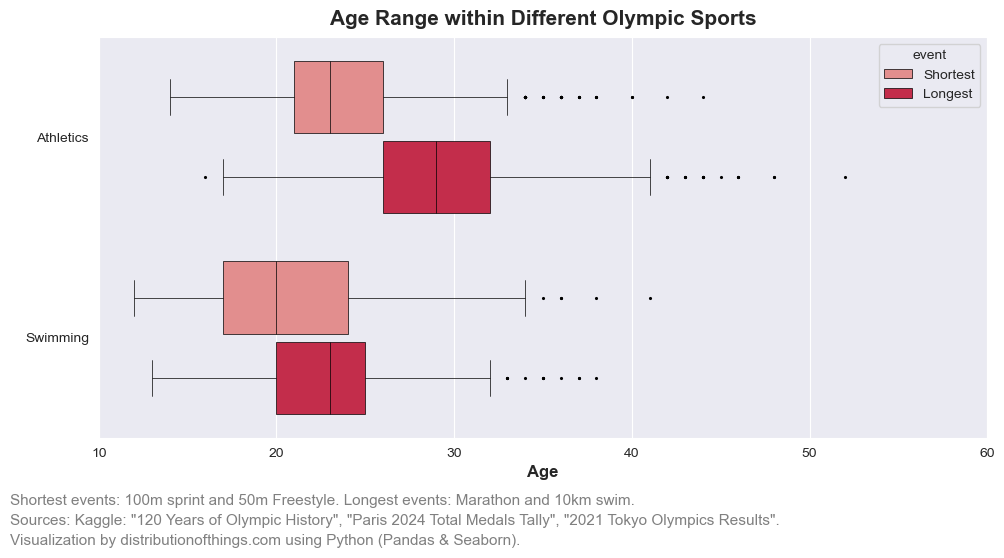

In [39]:
# Filter data set to only include selected athletics events
age_event = data.loc[(data['event'] == "Athletics Men's Marathon")
| (data['event'] == "Athletics Men's 100 metres")
| (data['event'] == "Athletics Women's Marathon")
| (data['event'] == "Athletics Women's 100 metres")
| (data['event'] == "Swimming Men's 50 metres Freestyle")
| (data['event'] == "Mens 10km")
| (data['event'] == "Swimming Women's 50 metres Freestyle")
| (data['event'] == "Women's 10km")]

# Renaming the cell content
age_event.loc[:, 'event'] = age_event['event'].replace({
    "Athletics Men's Marathon": "Longest", 
    "Athletics Men's 100 metres": "Shortest", 
    "Athletics Women's Marathon": "Longest", 
    "Athletics Women's 100 metres": "Shortest",
    "Swimming Men's 50 metres Freestyle": "Longest", 
    "Swimming Women's 50 metres Freestyle": "Shortest", 
    "Mens 10km": "Longest", 
    "Women's 10km": "Shortest"
})

age_event.loc[:, 'sport'] = age_event['sport'].replace({
    "Marathon Swimming": "Swimming"})


# Set the style for the plot
sns.set_style("darkgrid")

# Set the figure size
plt.figure(figsize=(10, 5))

# Customize outlier markers
flierprops = dict(marker='o', markerfacecolor='black', markersize=1.25, linestyle='none')

# Create the box plot with custom outlier markers
sns.boxplot(data=age_event, x='age', y='sport', hue='event', gap=.1, color='#0081C8', flierprops=flierprops,  linewidth=0.5, linecolor='black', dodge=True,
           palette={"Shortest": "lightcoral", "Longest": "crimson"})

# Labelling
plt.title('Age Range within Different Olympic Sports', fontsize=15, fontweight='bold', y=1.01)
plt.xlabel('Age', fontsize=12, fontweight='bold')
plt.ylabel('')
plt.xlim(10, 60)

# Citations
plt.figtext(0, -0.02, 'Shortest events: 100m sprint and 50m Freestyle. Longest events: Marathon and 10km swim.', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')
plt.figtext(0, -0.06, 'Sources: Kaggle: "120 Years of Olympic History", "Paris 2024 Total Medals Tally", "2021 Tokyo Olympics Results".', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')
plt.figtext(0, -0.1, 'Visualization by distributionofthings.com using Python (Pandas & Seaborn).', 
            wrap=True, horizontalalignment='left', fontsize=11, color='gray')

# Save figure
plt.tight_layout()
plt.savefig('Age Range within Different Olympic Sports.png', dpi=300, bbox_inches='tight')
plt.show()

## IV. What predicts medal wins best?

### The home effect (1988 – 2020)

H1. Hosting the Olympic Games leads to a significant increase in the number of medals won by a given delegation.

DV = Number of medals won by each country during the Olympic Games.
IV = Whether a country was the host nation in a given year (1 yes, 0 no)
Control = Total number of sports/events in each Olympic Game
Control = Size of the delegration from each country
Control = Number of participating countries

Analysis:
1. Regression analysis
2. Difference-in-Differences (accounting for the change in medal counts for host countries before and after they hosted the games, compared with countries that did not host).
3. T-test (To see if there's a statistically significant difference in the number of medals won by host nations compared to non-hosts.

In [1180]:
home = data[(data['year'] > 1987) & (data['year'] < 2024)].copy()
home = home.drop(columns=['age', 'height', 'weight', 'sex']) 

In [1184]:
# Adding a host country column
home['host_country'] = np.where(home['city'] == "Seoul", "South Korea",
                                np.where(home['city'] == "Barcelona", "Spain",
                                         np.where(home['city'] == "Atlanta", "USA",
                                                  np.where(home['city'] == "Sydney", "Australia",
                                                            np.where(home['city'] == "Athina", "Greece",
                                                                      np.where(home['city'] == "Beijing", "China",
                                                                                np.where(home['city'] == "London", "UK",
                                                                                          np.where(home['city'] == "Rio de Janeiro", "Brazil",
                                                                                                    np.where(home['city'] == "Tokyo", "Japan",
                                                  "Unknown")))))))))

# Independent variable: Adding a binary host country column (1 = host, 0 = not host)
home['hosting'] = np.where(home['country'] == home['host_country'], 1,
                     0)

In [1228]:
# Dependent variable: Adding a numeric medals column (3 = Gold, 2 = Silver, 1 = Bronze 0 = no medal)
var = {'Gold' : 3,
       'Silver' : 2,
      'Bronze' : 1}

home['medal_num'] = home['medal'].map(var).fillna(0)

In [1242]:
# Control variable: total events included in a given game
var = {'Seoul' : 237,
       'Barcelona' : 257,
       'Atlanta' : 271,
       'Sydney' : 300,
       'Athina' : 301,
       'Beijing' : 302,
       'London' : 302,
       'Rio de Janeiro' : 306,
      'Tokyo' : 306}

home['total_events'] = home['city'].map(var).fillna(0)

In [1248]:
# Control variable: Number of participating noc
var = {'Seoul' : 159,
       'Barcelona' : 169,
       'Atlanta' : 197,
       'Sydney' : 200,
       'Athina' : 201,
       'Beijing' : 204,
       'London' : 205,
       'Rio de Janeiro' : 207,
      'Tokyo' : 206}

home['participating_noc'] = home['city'].map(var).fillna(0)

In [1252]:
# Control variable: Delegation size
delegation_size = home.groupby(['year', 'noc']).size().reset_index(name='delegation_size')
home = pd.merge(home, delegation_size, on=['year', 'noc'], how='left')

In [1254]:
check = home.groupby(['year', 'host_country', 'city']).nunique()
check

,,,name,noc,sport,event,medal,country,hosting,medal_num,total_events,participating_noc,delegation_size
year,host_country,city,,,,,,,,,,,
1988,South Korea,Seoul,8443,159,27,237,3,155,2,4,1,1,83
1992,Spain,Barcelona,9380,169,29,257,3,167,2,4,1,1,84
1996,USA,Atlanta,10324,197,31,271,3,195,2,4,1,1,88
2000,Australia,Sydney,10639,200,34,300,3,198,2,4,1,1,92
2004,Greece,Athina,10537,201,34,301,3,199,2,4,1,1,86
2008,China,Beijing,10880,204,34,302,3,201,2,4,1,1,87
2012,UK,London,10502,205,32,302,3,202,2,4,1,1,87
2016,Brazil,Rio de Janeiro,11174,207,34,306,3,203,2,4,1,1,89
2020,Japan,Tokyo,11629,206,46,306,3,200,2,4,1,1,96


In [1278]:
# Regression analysis
import statsmodels.api as sm
X = home[['delegation_size']]
y = home['medal_num']

X = sm.add_constant(X)

In [1280]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              medal_num   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     4951.
Date:                Fri, 30 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:27:00   Log-Likelihood:            -1.3726e+05
No. Observations:              121389   AIC:                         2.745e+05
Df Residuals:                  121387   BIC:                         2.745e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0791      0.004     

### The home effect of the top 12 teams

Top 12: USA, Russia, UK, France, China, Germany, Italy, Australia, Japan, Hungary

### Award Money Paid out to Winning Athletes

### GDP, participation and winning